## Audio Data Processing Example

This sample, loads a dataset of audio files, and process them for training.


In [ ]:
#install a required libraries for audio processing
!conda install -c conda-forge librosa -y

In [50]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa.display
import librosa.feature
import random

def rand_range(low,high):
    return random.random()*(high-low)+low
    
class AudioDataLoader:
    def __init__(self,samples_length,sampling_rate=16000):
        self.samples_length=samples_length
        self.sampling_rate=sampling_rate
        
    def clip_data(self,data):
        if len(data)>self.samples_length:
            data=data[:self.samples_length]
        else:
            data=np.pad(data,(0,self.samples_length-len(data)),mode="constant")#pad with zeros
        return data
    
    def load_audio_file(self,path):
        try:
            #print(path)
            data,sr=librosa.load(path,sr=self.sampling_rate)
        except:
            return []
        return self.clip_data(data)
    
    def load_from_dir(self,path):
        files=os.listdir(path)
        samples=[]
        for f in files:
            s=self.load_audio_file(os.path.join(path,f))
            if s==[]:
                continue
                
            samples.append(s)
                
        return samples
    
    def load_dataset_from_folder(self,path,shuffle=True):
        labels=[]
        dirs=os.listdir(path)
        samples=[]
        idx=0
        for _,l in enumerate(dirs):
            samples_dir=os.path.join(path,l)
            if not os.path.isdir(samples_dir):
                continue
            labels.append(l)
            samples_paths=os.listdir(samples_dir)
            print("Loading {0}".format(l))
            for s in samples_paths:
                try:
                    s=self.load_audio_file(os.path.join(samples_dir,s))
                    if s==[]:
                        continue

                    sample=[np.array(s),idx]
                    samples.append(sample)
                except:
                    continue
            
            idx=idx+1

        if shuffle:
            random.shuffle(samples)
        return np.array(samples),np.array(labels)
    
### Features

    #Mel-frequency cepstral coefficients (MFCCs)
    def mfcc(self,data,nmfcc=128):
        return librosa.feature.mfcc(y=data, sr=self.sampling_rate,n_mfcc=nmfcc)
    
    def fft(self,data,fft=512):
        X = librosa.stft(data,n_fft=fft)
        Xdb = librosa.amplitude_to_db(abs(X),ref=np.max)
        return Xdb
### Visualize

    def plot_waveform(self,data):
        fig = plt.figure(figsize=(14, 8))
        plt.title('Raw wave ')
        plt.ylabel('Amplitude')
        librosa.display.waveplot(data, sr=self.sampling_rate)
        plt.show()

    def plot_specto(self,data,fft=512):
        X = librosa.stft(data,n_fft=fft,center=False)
        Xdb = librosa.amplitude_to_db(abs(X),ref=np.max)
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(Xdb, sr=self.sampling_rate, x_axis='time', y_axis='hz')
        plt.show()
        return X
    

In [58]:
loader=AudioDataLoader(samples_length=32000,sampling_rate=8000)
datasets=[]

samples,labels=loader.load_dataset_from_folder("datasets/audio")#load audio training samples
print("Loaded Labels")
for i,l in enumerate(labels):
    samples_count=len([s for s in samples if s[1]==i])
    print("{0}- [{1}] with total of {2} samples".format(i,l,samples_count))
    

Loading dogs


/anaconda3/envs/PML/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/anaconda3/envs/PML/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Loading cats


/anaconda3/envs/PML/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Loaded Labels
0- [dogs] with total of 55 samples
1- [cats] with total of 81 samples


cats


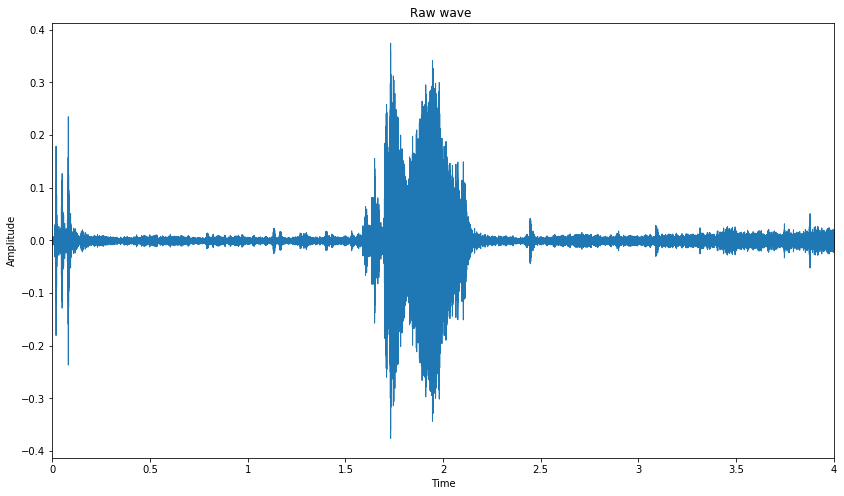

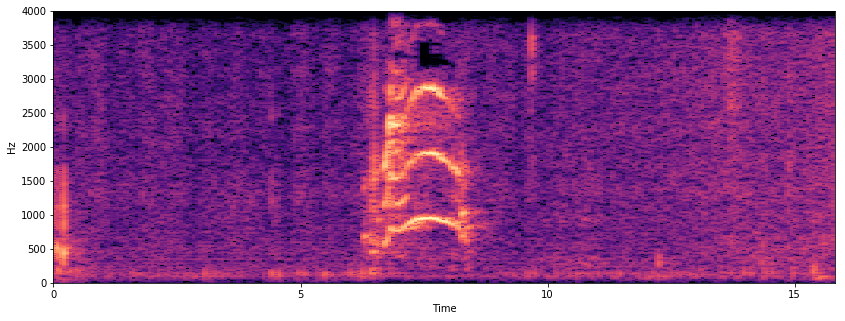

Waveform length:32000
FFT shape:(257, 247)=63479


In [110]:
index=random.randint(0,len(samples)-1)

print(labels[int(samples[index][1])])
loader.plot_waveform(samples[index][0])
fft=loader.plot_specto(samples[index][0],fft=512)


print("Waveform length:{0}".format(len(samples[index][0])))
print("FFT shape:{0}={1}".format(np.array(fft).shape,np.array(fft).shape[0]*np.array(fft).shape[1]))

ipd.Audio(samples[index][0],rate=loader.sampling_rate)

(40, 63)


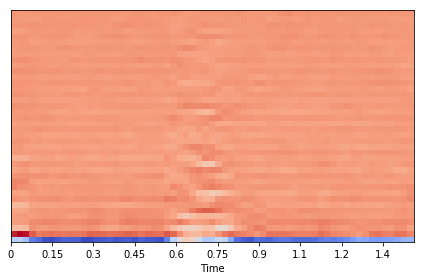

In [112]:
#display some features extracted from the audio
mfccs=loader.mfcc(samples[index][0],nmfcc=40)
print(np.array(mfccs).shape)
plt.figure()
librosa.display.specshow(mfccs, x_axis='time')
plt.tight_layout()

In [132]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils

X=[i[0] for i in samples]
Y=np.array([int(i[1]) for i in samples])

for i,x in enumerate(X):
    X[i]=np.array(loader.mfcc(x))
    #X[i]=np.array(loader.fft(x))

    
X=np.array(X)

X=X.reshape(X.shape[0],X.shape[1]*X.shape[2])
print(X.shape)

#normalize values
mean=np.mean(X,axis=0)
std=np.std(X,axis=0)
x_train=(X-mean)/std

#prepare labels
nb_classes=len(labels)
y_train = utils.to_categorical(Y, nb_classes)

X_train,X_test,Y_train,Y_test=train_test_split(x_train,y_train,test_size=0.1)

print("Training using: {0} samples".format(len(X_train)))
print("Validating using: {0} samples".format(len(X_test)))

(136, 8064)
Training using: 122 samples
Validating using: 14 samples


In [133]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

def create_model(input_len,nbclasses,firstLayer,nlayers,dropout=0.3):
    model=models.Sequential()
    model.add(layers.Dense(firstLayer,activation='relu',input_shape=(input_len,)))
    model.add(layers.Dropout(dropout))
    for l in nlayers:
        model.add(layers.Dense(l,activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nbclasses,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [142]:

from tensorflow.keras.callbacks import TensorBoard
from time import time

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

TrainModel=True #Set to False to load pretrained model

X_train=np.array(X_train)
X_test=np.array(X_test)

Y_train=np.array(Y_train)
Y_test=np.array(Y_test)

model=create_model(X_train.shape[1],nb_classes,32,[32],dropout=0.3)
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=8, callbacks=[tensorboard])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 32)                258080    
_________________________________________________________________
dropout_53 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_54 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 2)                 66        
Total params: 259,202
Trainable params: 259,202
Non-trainable params: 0
_________________________________________________________________
Train on 122 samples, validate on 14 samples
Epoch 1/100
122/122 [==============================] - 1s 5ms/step - loss: 0.5786 - acc: 0.

122/122 [==============================] - 0s 762us/step - loss: 0.0874 - acc: 0.9918 - val_loss: 0.2409 - val_acc: 0.9286
Epoch 54/100
122/122 [==============================] - 0s 763us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.2500 - val_acc: 0.9286
Epoch 55/100
122/122 [==============================] - 0s 577us/step - loss: 0.0154 - acc: 0.9918 - val_loss: 0.2607 - val_acc: 0.9286
Epoch 56/100
122/122 [==============================] - 0s 603us/step - loss: 6.2125e-04 - acc: 1.0000 - val_loss: 0.2648 - val_acc: 0.9286
Epoch 57/100
122/122 [==============================] - 0s 596us/step - loss: 0.0630 - acc: 0.9918 - val_loss: 0.2552 - val_acc: 0.9286
Epoch 58/100
122/122 [==============================] - 0s 610us/step - loss: 0.0121 - acc: 0.9918 - val_loss: 0.2423 - val_acc: 0.9286
Epoch 59/100
122/122 [==============================] - 0s 690us/step - loss: 0.0218 - acc: 0.9918 - val_loss: 0.2402 - val_acc: 0.9286
Epoch 60/100
122/122 [==============================] - 0

In [135]:

#load test samples
sample_test,labels_test=loader.load_dataset_from_folder("test/audio/")
print("Loaded Test Samples")
for i,l in enumerate(labels_test):
    samples_count=len([s for s in sample_test if s[1]==i])
    print("{0}- [{1}] with total of {2} samples".format(i,l,samples_count))
    

Loading dogs


/anaconda3/envs/PML/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/anaconda3/envs/PML/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Loading cats


/anaconda3/envs/PML/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Loaded Test Samples
0- [dogs] with total of 50 samples
1- [cats] with total of 83 samples


In [143]:
def preprocess_sample(sample):
    sample=np.array(loader.mfcc(sample)) #get  features
    sample=sample.reshape(sample.shape[0]*sample.shape[1]) #flatten to 1D array
    sample=(sample-mean)/std #normalize values
    return sample

total=np.zeros(len(labels))
err=np.zeros(len(labels))
for s in sample_test:
    
    sample=preprocess_sample(s[0])#preprocess test sample
    res=model.predict(np.array([sample]))#predict its label
    
    total[s[1]]=total[s[1]]+1
    if labels_test[s[1]] !=labels[np.argmax(res)]:
        err[s[1]]=err[s[1]]+1
        flag="Error"
    else:
        flag="Correct"
    #print("{0} - Original: {1}  Predicted: {2}".format(flag,labels_test[s[1]],labels[np.argmax(res)]))
    
for i,e in enumerate(err):
    print("Accuracy for [{0}] is {1}%".format(labels_test[i], 100-int(100*e/float(total[i]))))

Accuracy for [dogs] is 86%
Accuracy for [cats] is 84%


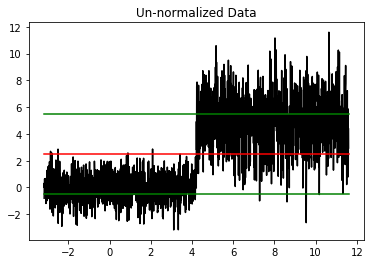

In [167]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


rng = np.random.RandomState(1000)  # deterministic random data
a = np.hstack((rng.normal(size=1000),rng.normal(loc=5, scale=2, size=1000)))
#plt.hist(a, bins=20)  # arguments are passed to np.histogram
plt.title("Un-normalized Data")

x_axis = np.linspace(np.min(a), np.max(a), len(a))
# Mean = 0, SD = 2.
#plt.plot(x_axis, norm.pdf(x_axis,meanA,stdA))
meanA=np.mean(a)
stdA=np.std(a)
plt.plot(x_axis,a,'k')
plt.plot([np.min(a), np.max(a)],[meanA,meanA],'r')
plt.plot([np.min(a), np.max(a)],[meanA-stdA,meanA-stdA],'g')
plt.plot([np.min(a), np.max(a)],[meanA+stdA,meanA+stdA],'g')
plt.show()



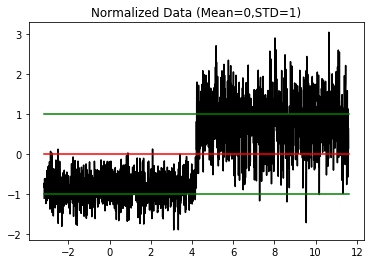

In [169]:

b=(a-meanA)/stdA
plt.plot(x_axis,b,'k')

meanB=np.mean(b)
stdB=np.std(b)
plt.title("Normalized Data (Mean=0,STD=1)")
plt.plot([np.min(a), np.max(a)],[meanB,meanB],'r')
plt.plot([np.min(a), np.max(a)],[meanB-stdB,meanB-stdB],'g')
plt.plot([np.min(a), np.max(a)],[meanB+stdB,meanB+stdB],'g')

plt.show()